In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
12300,Newly married man held for impregnating minor ...,A newly married man was arrested in Tamil Nadu...
524,India A win 3rd straight one-day vs England Li...,The India A side clinched the unofficial one-d...
37180,"Man denied table at eatery says he's PM, gets ...","A man, denied a reservation at a Moroccan rest..."
71545,"If there's Alia, there's also Kangana: Kareena...","Kareena Kapoor, while talking about nepotism i..."
55775,Rajya Sabha passes bill granting greater auton...,The Rajya Sabha on Tuesday passed a bill grant...
70679,Labourers to get unique ID numbers: Union Labo...,Union Minister of State for Labour and Employm...
51843,WWE wrestler overturns truck after being fired...,After getting fired by RAW General Manager Kur...
92870,Girl makes 'Why you should date me' PPT for crush,Twitter user Lizzy Fenton has created a 'Why y...
14949,I include nature in Sabka Saath: PM Modi on ge...,Upon receiving United Nations' highest environ...
80140,"SBI Life Insurance files for IPO, to raise ove...","SBI Life Insurance, a unit of State Bank of In..."


In [5]:
# 불용어 다운로드
nltk.download('stopwords')
stop_words_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# 데이터 전처리
data.drop_duplicates(subset = ['text'], inplace=True) # 중복 제거
data.dropna(axis=0, inplace=True)                     # 결측 제거

data['text'] = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))
data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


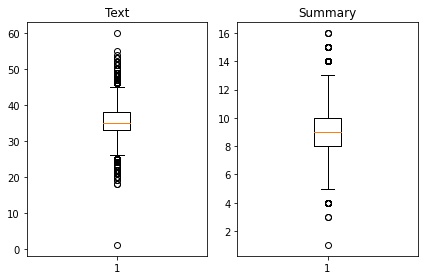

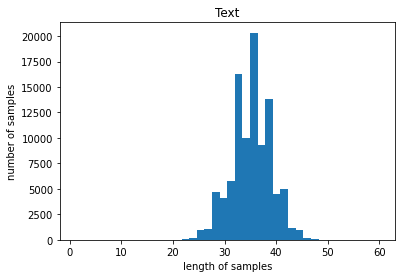

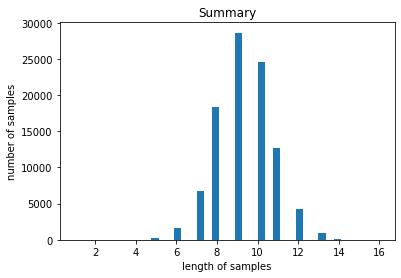

In [11]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
# max len 설정
text_max_len = 40
summary_max_len = 10

In [13]:
# max len보다 긴 샘플 제거
data_sampled = data[data.apply(lambda x : len(x['text'].split())<=text_max_len, axis=1)]
data_sampled = data_sampled[data_sampled.apply(lambda x : len(x['headlines'].split())<=summary_max_len, axis=1)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [14]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data_sampled['decoder_input'] = data_sampled['headlines'].apply(lambda x : 'sostoken '+ x)
data_sampled['decoder_target'] = data_sampled['headlines'].apply(lambda x : x + ' eostoken')
data_sampled.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [35]:
# input 정의
encoder_input = np.array(data_sampled['text']) # 인코더의 입력
decoder_input = np.array(data_sampled['decoder_input']) # 디코더의 입력
decoder_target = np.array(data_sampled['decoder_target']) # 디코더의 레이블

In [36]:
# train test split
from sklearn.model_selection import train_test_split
encoder_input_train, encoder_input_test = train_test_split(encoder_input, test_size=0.2, shuffle=False)
decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(decoder_input, decoder_target, test_size=0.2, shuffle=False)

In [37]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60337
등장 빈도가 6번 이하인 희귀 단어의 수: 41187
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19150
단어 집합에서 희귀 단어의 비율: 68.26159736148631
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.104311930634371


In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26959
등장 빈도가 5번 이하인 희귀 단어의 수: 17914
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9045
단어 집합에서 희귀 단어의 비율: 66.44905226454986
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.861268373137878


In [117]:
print(len(encoder_input_train),len(encoder_input_test))
print(len(decoder_input_train),len(decoder_input_test),len(decoder_target_train),len(decoder_target_test))
print(encoder_input[:10])

59281 14821
59281 14821 59281 14821
['new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years'
 'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre'
 'congress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin votes bypoll victory congress taken total seats member assembly election ramgarh seat

In [39]:
# tokenizer for encoder
src_vocab = 18000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 18,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)  # 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 샘플 출력
print(encoder_input_train[:3])

# tokenizer for decoder
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

[[24, 863, 1063, 3, 814, 717, 429, 4962, 64, 317, 10, 112, 86, 112, 429, 201, 3, 288, 113, 112, 1014, 294, 6085, 1416, 7902, 1451, 197, 358, 112, 1690, 3, 508, 2703, 2735, 245, 429, 122, 538], [17828, 149, 17829, 1625, 701, 702, 4633, 303, 2224, 14261, 511, 1584, 2509, 701, 2006, 149, 998, 434, 23, 6, 702, 3389, 1957, 10207, 6811, 3899, 170, 2131, 7051, 149, 998, 434, 23], [557, 559, 13636, 13036, 599, 100, 461, 1350, 783, 1577, 1616, 40, 3293, 315, 1329, 3, 27, 657, 236, 27, 897, 783, 10, 6086, 1412, 174, 264, 3864, 13636, 391, 63, 5427, 12036]]


In [40]:
# 길이 1인거 드랍
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [41]:
# 패딩
encoder_input_train_pdd = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test_pdd = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train_pdd = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='pre')
decoder_target_train_pdd = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='pre')
decoder_input_test_pdd = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='pre')
decoder_target_test_pdd = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='pre')

In [42]:
# 모델 설계 : 인코더
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
    # encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [43]:
# 모델 설계 : 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
    # decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [44]:
# 어텐션
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [45]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train_pdd, decoder_input_train_pdd], y=decoder_target_train_pdd, \
          validation_data=([encoder_input_test_pdd, decoder_input_test_pdd], decoder_target_test_pdd), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 25s 83ms/step - loss: 6.2514 - val_loss: 5.7621
Epoch 2/50
232/232 [==============================] - 18s 79ms/step - loss: 5.8986 - val_loss: 5.7980
Epoch 3/50
232/232 [==============================] - 18s 80ms/step - loss: 5.7624 - val_loss: 5.5625
Epoch 4/50
232/232 [==============================] - 19s 81ms/step - loss: 5.5109 - val_loss: 5.3105
Epoch 5/50
232/232 [==============================] - 19s 83ms/step - loss: 5.2696 - val_loss: 5.1295
Epoch 6/50
232/232 [==============================] - 20s 85ms/step - loss: 5.0360 - val_loss: 4.9659
Epoch 7/50
232/232 [==============================] - 20s 88ms/step - loss: 4.8068 - val_loss: 4.8204
Epoch 8/50
232/232 [==============================] - 20s 86ms/step - loss: 4.6129 - val_loss: 4.6983
Epoch 9/50
232/232 [==============================] - 20s 86ms/step - loss: 4.4388 - val_loss: 4.6150
Epoch 10/50
232/232 [==============================] - 20s 86ms/step - loss: 4.281

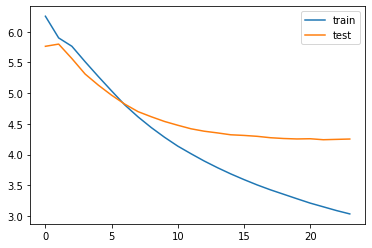

In [46]:
# 결과 출력
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
# 인퍼런스 단계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i!=1 and i!=2):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [51]:
# 결과 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test_pdd[i]))
    print("실제 요약 :", seq2summary(decoder_input_test_pdd[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test_pdd[i].reshape(1, text_max_len)))
    print("\n")

원문 : actor arjun kapoor revealed father boney kapoor thought gay father asked girlfriend said hanging three four friends club worried dad straight added arjun said initially shocked father question 
실제 요약 : case come feature queen man persons response share 
예측 요약 :  arjun was the father of him arjun on anniversary


원문 : zhang member aamir khan fan club china said video made gift actor chose song aamir sung really cool movie added zhang said chinese moved family ties depicted dangal 
실제 요약 : robbery officials man nobel us whatsapp given career 
예측 요약 :  aamir khan to play villain in upcoming film reports


원문 : pakistani actor adnan siddiqui said people india pakistan love respect art adding see passports purchase ticket see film also said believes nations find peace art share history values customs adnan played sridevi husband mom 
실제 요약 : billion common weapons cloud police interim video travelling mumbai named 
예측 요약 :  pak films to be celebrated as sri sri lanka


원문 : reacting zi

In [ ]:
# Summa 사용
import requests
from summa.summarizer import summarize
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text